In [1]:
from roikit import ROIs
rois = ROIs('20161028_1', datapath='../data/')

In [10]:
# rois.data_rawtraces = rois.data_rawtraces.loc[:2]

In [2]:
rois.compute_rf(recompute=True)

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [12]:
rois.compute_rf(recompute=False)

`data_rf` is already computed. To recompute, set `recompute=True`.


In [13]:
rois.compute_cntr(recompute=False)

`data_cntr` is already computed. To recompute, set `recompute=True`.


In [16]:
rois.data_rf.columns

Index(['recording_id', 'roi_id', 'RF', 'sRF', 'tRF', 'RF_upsampled'], dtype='object')

In [3]:
rois.compute_cntr(recompute=True)

KeyError: 232

In [15]:
rois.data_cntr

,expdate,rec_id,roi_id,RF_cntr_upsampled,cntrs_offset,distance_from_RF_center_to_soma,distance_from_RF_center_to_ROI,cntr_quality
0,20161028_1,0,0,"[[[101.35124595946024, 162.9905389686728], [10...","[[4.930662951539631, -11.822314528975141]]",12.809315,12.809315,True
1,20161028_1,1,1,"[[[120.71456222144573, 147.28536831524764], [1...","[[7.314363213630344, -8.516890551912127]]",35.692195,11.226635,True
2,20161028_1,1,2,"[[[111.34070371231459, 142.6304202532466], [11...","[[1.632708964386211, -6.367389290798542]]",24.269364,6.573385,True
3,20161028_1,1,3,"[[[117.28627704928888, 139.97044993210318], [1...","[[8.40915674154354, -7.757176168961877]]",32.409094,11.440616,True
4,20161028_1,1,4,"[[[137.97921012252579, 141.96542767296074], [1...","[[3.11131446282144, 4.850856738102152]]",36.583270,5.762906,True
...,...,...,...,...,...,...,...,...
228,20161028_1,15,6,"[[[60.571380937504095, 163.3406131658142], [60...","[[11.564330912006398, -13.426381489058826]]",65.704743,17.720087,True
229,20161028_1,15,7,"[[[63.27269643047446, 176.6404647715314], [63....","[[11.47186326153519, -9.348695183976616]]",69.152614,14.798708,True
230,20161028_1,15,8,"[[[88.49180289527246, 179.3004350926749], [88....","[[56.560978535527866, -29.728201945610948]]",20.100453,63.897655,False
231,20161028_1,15,9,NaN,"[nan, nan]",NaN,NaN,False


In [4]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
def rescale_data(data):
    return (data - data.min()) / (data.max() - data.min())

def get_contour(data, stack_pixel_size, 
                rf_pixel_size=30):

    data = rescale_data(data)
    levels = np.arange(60, 75, 5)/100
    
    CS = plt.contour(data, levels=levels)
    plt.clf()
    plt.close()

    res = 0
    for i in range(len(levels)):

        ps = CS.collections[i].get_paths()
        
        all_cntrs = [p.vertices for p in ps]

        cntrs_size = [cv2.contourArea(cntr.astype(np.float32))*stack_pixel_size**2/1000 for cntr in all_cntrs]

        # if i == 0:
        #     res = pd.Series([all_cntrs, cntrs_size])
        # else:
        #     tmp = pd.Series([all_cntrs, cntrs_size])
        #     res = res.append(tmp)
        
        good_cntrs = [cntr[:, ::-1] for cntr in all_cntrs if (cntr[0] == cntr[-1]).all() and cv2.contourArea(cntr.astype(np.float32))*stack_pixel_size**2/1000 > 2.5]
        good_cntrs_size = [cv2.contourArea(cntr.astype(np.float32))*stack_pixel_size**2/1000 for cntr in good_cntrs]

        if i == 0:
            res = pd.Series([good_cntrs, good_cntrs_size])
        else:
            tmp = pd.Series([good_cntrs, good_cntrs_size])
            res = res.append(tmp)

    res.index = np.arange(len(levels) * 2)
    return res

def get_irregular_index(cnts):
    irregular_index = []
    
    if len(cnts) == 0: return 1
    
    for j, cnt in enumerate(cnts):
        hull = cv2.convexHull(cnt.astype(np.float32)).flatten().reshape(-1, 2)
        hull = np.vstack([hull, hull[0]])
        
        RFarea = cv2.contourArea(cnt.astype(np.float32))
        CHarea = cv2.contourArea(hull.astype(np.float32))

        irregular_index.append((CHarea - RFarea) / CHarea)
            
    return np.max(irregular_index)

In [5]:
labels

NameError: name 'labels' is not defined

In [6]:
import itertools

data_cntr = pd.DataFrame()
data_cntr[['recording_id', 'roi_id']] = rois.data_rawtraces[['rec_id', 'roi_id']]

# levels = np.linspace(0, 1, 41)[::2][10:-6]
# levels = np.arange(0.6, 0.72, 0.025)
levels = np.arange(60, 75, 5)/ 100
labels = [['RF_cntr_upsampled_{0}'.format(int(lev * 100)), 'sRF_asd_upsampled_cntr_size_{0}'.format(int(lev * 100)) ] for lev in levels]
labels = list(itertools.chain(*labels))

data_cntr[labels] = rois.data_rf['RF_upsampled'].apply(lambda x: get_contour(x, rois.data_stack['pixel_size'][0], 30))

In [31]:
data_cntr

,recording_id,roi_id,RF_cntr_upsampled_60,sRF_asd_upsampled_cntr_size_60,RF_cntr_upsampled_65,sRF_asd_upsampled_cntr_size_65,RF_cntr_upsampled_70,sRF_asd_upsampled_cntr_size_70,cntr_irregularity_60,cntr_counts_60,...,RF_cntr_tree_upsampled_70,RF_cntr_calibrated_70,cntrs_offset_70,distance_from_RF_center_to_soma_70,distance_from_RF_center_to_ROI_70,RF_cntr_upsampled,cntrs_offset_,distance_from_RF_center_to_soma,distance_from_RF_center_to_ROI,cntr_quality
0,0,0,"[[[289.9050742733211, 508.0], [289.73244470886...",[13.665062969177871],"[[[295.82824639482044, 508.00000000000006], [2...",[11.465864364377792],"[[[301.9765529402513, 507.00000000000006], [30...",[9.457260821412738],0.000236,1,...,"[[[200.81216712556807, 337.1512382049323], [20...","[[[190.7496900465341, 278.7078978919516], [190...","[[54.75690232634054, 156.31757831706986]]",202.910161,165.630624,"[[[295.82824639482044, 508.00000000000006], [2...","[[56.146919796243225, 161.0952364513095]]",202.929693,170.599390,True
1,1,1,"[[[276.8866766511628, 504.0], [276.76053679523...",[14.537157673752963],"[[[281.95678029769726, 507.0], [281.8206550852...",[12.23016638421407],"[[[286.9132172191503, 511.0], [286.93298650980...",[10.069477844949718],0.000004,1,...,"[[[157.7951606366809, 181.81120852607575], [15...","[[[147.73268355764694, 123.36786821309498], [1...","[[6.107748124498073, -28.386923256939667]]",29.447263,29.036563,"[[[281.95678029769726, 507.0], [281.8206550852...","[[7.122376485128626, -24.878151590084656]]",28.938192,25.877609,True
2,1,2,"[[[272.9709434725349, 550.9999999999999], [272...",[13.137589391075995],"[[[278.9952836817899, 542.0], [278.98233804857...",[11.060131960871988],"[[[284.93660300835757, 507.99999999999994], [2...",[9.100862034199647],0.000142,1,...,"[[[156.48072685241615, 179.81623078521812], [1...","[[[146.4182497733822, 121.37289047223736], [14...","[[6.090774498927686, -29.72273486266124]]",23.355188,30.340377,"[[[278.9952836817899, 542.0], [278.98233804857...","[[6.765609188851641, -24.357828549997024]]",23.373334,25.279978,True
3,1,3,"[[[276.9988401591988, 569.0], [276.92697716016...",[14.94608952246557],"[[[282.96046145494284, 569.0], [282.8987984843...",[12.484132738503071],"[[[289.9564559494751, 558.0], [289.89892535399...",[10.211000634074836],0.000112,1,...,"[[[159.8188918123855, 213.06585979951126], [15...","[[[149.75641473335153, 154.6225194865305], [14...","[[-1.7670920151286964, -9.873690458965797]]",32.132436,10.030572,"[[[282.96046145494284, 569.0], [282.8987984843...","[[-0.9192039515714328, -6.523934875620171]]",31.440967,6.588373,True
4,1,4,"[[[282.9414317412189, 505.0], [282.77710152951...",[11.610263277555807],"[[[287.98032123026695, 511.0], [287.9810646314...",[9.616656624533142],"[[[294.92911336431615, 511.0], [294.9128034873...",[7.795107086239921],0.000139,1,...,"[[[163.12567209755827, 181.81120852607575], [1...","[[[153.0631950185243, 123.36786821309498], [15...","[[-1.6476965071288987, 1.4410768043469488]]",44.239391,2.188974,"[[[287.98032123026695, 511.0], [287.9810646314...","[[-0.8891210752677807, 4.9988911871597]]",43.136782,5.077347,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,15,6,"[[[280.9816606557599, 563.0], [280.85829035777...",[10.477409936784074],"[[[285.93794344995564, 568.0], [285.7991609856...",[8.58324708172071],"[[[291.9273779872161, 570.0], [291.84258515738...",[6.875589232082766],0.000402,1,...,"[[[61.12954034380513, 259.04577076294163], [61...","[[[51.06706326477118, 200.60243044996088], [51...","[[0.38529745294856355, 27.49541612803546]]",114.497340,27.498116,"[[[285.93794344995564, 568.0], [285.7991609856...","[[1.7230625893063518, 32.360313511778514]]",114.069006,32.406154,True
229,15,7,"[[[278.9686115968455, 510.0], [278.88447754758...",[16.46426747901158],"[[[290.8530214872675, 509.99999999999994], [29...",[13.29780619422602],"[[[297.9621373674053, 555.0], [297.89259341091...",[10.419249621247374],0.035733,1,...,"[[[65.14261055544148, 249.07088

In [14]:
rfcenter =np.array([15,20]) * int(30) * 0.5
padding = rois.data_rois.recording_center.apply(
    lambda x: (rfcenter-np.array(x) * rois.data_stack['pixel_size'][0]).astype(int)
)
padding = np.vstack([[0,0], np.vstack(padding.values)])

rois_pos_all = np.vstack([rois.soma, np.vstack(rois.data_rois.roi_pos)])

In [13]:
rois_pos.shape

(233, 3)

In [15]:
for lev in np.arange(60, 75, 5):
    
    data_cntr['cntr_irregularity_{}'.format(lev)] = data_cntr['RF_cntr_upsampled_{}'.format(lev)].apply(lambda x: get_irregular_index(x))
    data_cntr['cntr_counts_{}'.format(lev)] = data_cntr['RF_cntr_upsampled_{}'.format(lev)].apply(lambda x: len(x))
    data_cntr['cntr_quality_{}'.format(lev)] = np.logical_and(data_cntr['cntr_counts_{}'.format(lev)] < 2, 
                                                            data_cntr['cntr_irregularity_{}'.format(lev)] < 0.1)

    res = []
    for j, roi_contours in enumerate(data_cntr['RF_cntr_upsampled_{}'.format(lev)]):
        res.append([x * rois.data_stack['pixel_size'][0] - padding[j] for x in roi_contours]) 
    data_cntr['RF_cntr_tree_upsampled_{}'.format(lev)] = pd.Series(res) 
    
    quality = data_cntr['cntr_quality_{}'.format(lev)].copy()
    all_cntrs = data_cntr['RF_cntr_tree_upsampled_{}'.format(lev)][quality]
    all_cntrs_center = all_cntrs.apply(lambda x: [np.mean(y,0) for y in x][0])
    rois_pos = rois_pos_all[:, :2][quality]
    rois_offsets = np.vstack(all_cntrs_center) - rois_pos
    rois_offset = rois_offsets.mean(0)
    cntrs_calibrate_to_rois = all_cntrs.apply(lambda x: [y - rois_offset for y in x])
    
    data_cntr['RF_cntr_calibrated_{}'.format(lev)] = cntrs_calibrate_to_rois
    
    data_cntr['cntrs_offset_{}'.format(lev)] = data_cntr['RF_cntr_calibrated_{}'.format(lev)][data_cntr['RF_cntr_calibrated_{}'.format(lev)].notnull()].apply(lambda x: np.array([y.mean(0) for y in x])) - rois.data_rois.roi_pos.apply(lambda x:x[:2])
    data_cntr['distance_from_RF_center_to_soma_{}'.format(lev)] = data_cntr['RF_cntr_tree_upsampled_{}'.format(lev)][data_cntr['RF_cntr_tree_upsampled_{}'.format(lev)].notnull()].apply(lambda x: np.mean([np.sqrt(np.sum((y.mean(0) - rois.soma[:2])**2)) for y in x]))
    data_cntr['distance_from_RF_center_to_ROI_{}'.format(lev)] = data_cntr['cntrs_offset_{}'.format(lev)][data_cntr['cntrs_offset_{}'.format(lev)].notnull()].apply(lambda x: np.mean([np.sqrt(np.sum(y**2)) for y in x]))    



data_cntr['RF_cntr_upsampled'] = data_cntr['RF_cntr_upsampled_65'] 
data_cntr['cntrs_offset_'] = data_cntr['cntrs_offset_65'] 
data_cntr['distance_from_RF_center_to_soma'] = data_cntr['distance_from_RF_center_to_soma_65'] 
data_cntr['distance_from_RF_center_to_ROI'] = data_cntr['distance_from_RF_center_to_ROI_65'] 

data_cntr['cntr_quality'] = data_cntr[[
                      'cntr_quality_60', 
                      'cntr_quality_65', 
                      'cntr_quality_70'
                      ]].all(1)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [17]:
rois.data_cntr = data_cntr

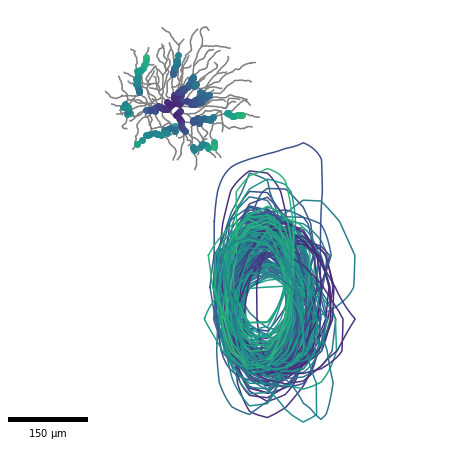

In [18]:
rois.plot_cntr()

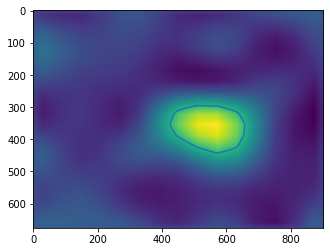

In [27]:
plt.imshow(rois.data_rf.loc[0]['RF_upsampled'])
plt.plot(cntr[0][:, 1], cntr[0][:, 0])

In [25]:
cntr

[array([[295.82824639, 508.        ],
        [295.63032569, 509.        ],
        [295.434088  , 510.        ],
        ...,
        [296.02787184, 507.        ],
        [296.        , 507.13910526],
        [295.82824639, 508.        ]])]

In [23]:
cntr = rois.data_cntr.loc[0]['RF_cntr_upsampled']

In [ ]:
rois.data_rawtraces

In [28]:
cntr_all = rois.data_cntr['RF_cntr_upsampled'][rois.data_cntr['cntr_quality']]

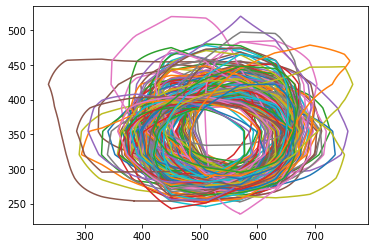

In [30]:
for cntr in cntr_all:
    plt.plot(cntr[0][:, 1], cntr[0][:, 0])

In [ ]:
cntr_all